/var/folders/rb/s8fz0j0d7xq20qvk9cm9vf9m0000gp/T/ipykernel_99585/1934266994.py:17: DtypeWarning: Columns (21,22,38,39,46,47) have mixed types. Specify dtype option on import or set low_memory=False.
  suggestions_dat = pd.read_csv('../data/suggestions.csv')
/Users/zhiduokatara/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


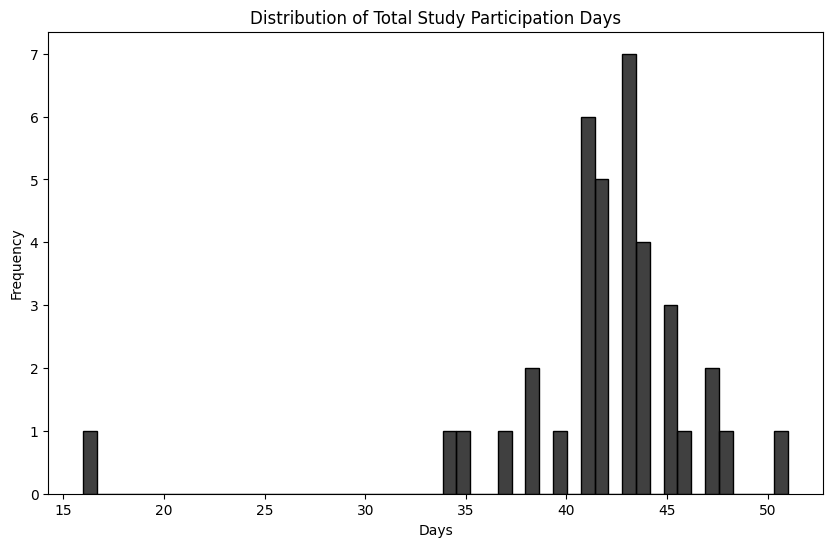

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, iqr
import statsmodels.api as sm
from statsmodels.formula.api import glm
from statsmodels.genmod.families import NegativeBinomial, Gamma
from pandas.api.types import CategoricalDtype
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Load data files
steps_gf = pd.read_csv('../data/gfsteps.csv')
steps_jb = pd.read_csv('../data/jbsteps.csv')
users_info = pd.read_csv('../data/users.csv')
suggestions_dat = pd.read_csv('../data/suggestions.csv')

# Initial data processing for users_info
mydata_qs = users_info[['user.index', 'totaldays'] + [col for col in users_info.columns if col.startswith("selfeff")]].copy()
mydata_qs['selfeff.badmood.intake_r'] = 6 - mydata_qs['selfeff.badmood.intake']
mydata_qs['selfeff.notime.intake_r'] = 6 - mydata_qs['selfeff.notime.intake']
mydata_qs['selfeff.tired.intake_r'] = 6 - mydata_qs['selfeff.tired.intake']
mydata_qs['selfeff.vaca.intake_r'] = 6 - mydata_qs['selfeff.vaca.intake']
mydata_qs['selfeff.precip.intake_r'] = 6 - mydata_qs['selfeff.precip.intake']
mydata_qs['selfeff.intake_r'] = mydata_qs[['selfeff.notime.intake_r', 'selfeff.tired.intake_r', 
                                           'selfeff.vaca.intake_r', 'selfeff.precip.intake_r', 
                                           'selfeff.badmood.intake_r']].sum(axis=1)


plt.figure(figsize=(10, 6))
#sns.histplot(mydata_qs[mydata_qs['user.index'] != 29]['totaldays'], bins=51, kde=False, color="black")
sns.histplot(mydata_qs['totaldays'], bins=51, kde=False, color="black")
plt.title("Distribution of Total Study Participation Days")
plt.xlabel("Days")
plt.ylabel("Frequency")
plt.savefig("hist_totalday.png", transparent=True)
plt.show()


In [2]:
# Check initial unique users
print("Unique users in `steps_gf`:", steps_gf['user.index'].nunique())
print("Unique users in `suggestions_dat`:", suggestions_dat['user.index'].nunique())
print("Unique users in `users_info`:", users_info['user.index'].nunique())


Unique users in `steps_gf`: 27
Unique users in `suggestions_dat`: 37
Unique users in `users_info`: 37


In [3]:
# Step 2: Notification type data and merge steps and user data
notif_type = suggestions_dat[['user.index', 'decision.index', 'send', 'send.active', 'send.sedentary']]
steps_notif = pd.merge(steps_gf, notif_type, on=['user.index', 'decision.index'], how='outer')
steps_notif_users = pd.merge(steps_notif, mydata_qs, on='user.index', how='outer')
steps_notif_users['send'] = steps_notif_users['send'].astype(bool)
steps_notif_users['send.active'] = steps_notif_users['send.active'].astype(bool)


# Sort and arrange data
steps_notif_users = steps_notif_users.sort_values(by=['steps.utime']).reset_index(drop=True)
steps_notif_users['user.index'] = steps_notif_users['user.index'].astype(int)

# Summary statistics
print(steps_notif_users['steps'].describe())

count    197524.000000
mean         27.155085
std          88.415296
min           1.000000
25%           1.000000
50%           4.000000
75%          27.000000
max        4929.000000
Name: steps, dtype: float64


In [4]:
# Function to handle missing data in 'steps' column using LOCF
def handle_missing_steps_locf(data):
    """Apply Last Observation Carried Forward (LOCF) to 'steps' column."""
    data['steps'] = data['steps'].fillna(method='ffill')
    return data

# Apply LOCF to steps data
steps_notif_users = handle_missing_steps_locf(steps_notif_users)


/var/folders/rb/s8fz0j0d7xq20qvk9cm9vf9m0000gp/T/ipykernel_99585/4146755190.py:4: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['steps'] = data['steps'].fillna(method='ffill')


In [5]:
# Filter data for steps analysis
clean_steps_notif_users = steps_notif_users.query("`send` == True and `user.index` not in [29, 22]").copy()
clean_steps_notif_users['notif_type'] = np.where(clean_steps_notif_users['send.active'], 'Active', 'Sedentary')
clean_steps_notif_users['steps_date'] = pd.to_datetime(clean_steps_notif_users['steps.utime']).dt.date
clean_steps_notif_users['day'] = clean_steps_notif_users.groupby('user.index')['steps_date'].transform(lambda x: pd.factorize(x)[0] + 1)

clean_steps_notif_users

,user.index,steps.utime,steps,decision.index,slot,decision.index.following.dec,slot.following.dec,send,send.active,send.sedentary,...,selfeff.exit,selfeff.badmood.intake_r,selfeff.notime.intake_r,selfeff.tired.intake_r,selfeff.vaca.intake_r,selfeff.precip.intake_r,selfeff.intake_r,notif_type,steps_date,day
0,1,2015-07-22 14:52:49.555227,1.0,NaN,NaN,0.0,2.0,True,True,NaN,...,20.0,2,3,3,1,2,11,Active,2015-07-22,1
1,1,2015-07-22 14:53:49.555227,55.0,NaN,NaN,0.0,2.0,True,True,NaN,...,20.0,2,3,3,1,2,11,Active,2015-07-22,1
2,1,2015-07-22 14:54:24.957986,1.0,NaN,NaN,0.0,2.0,True,True,NaN,...,20.0,2,3,3,1,2,11,Active,2015-07-22,1
3,1,2015-07-22 14:54:25.360817,100.0,NaN,NaN,0.0,2.0,True,True,NaN,...,20.0,2,3,3,1,2,11,Active,2015-07-22,1
4,1,2015-07-22 14:55:25.913032,1.0,NaN,NaN,0.0,2.0,True,True,NaN,...,20.0,2,3,3,1,2,11,Active,2015-07-22,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201119,37,NaN,3.0,223.0,NaN,NaN,NaN,True,False,True,...,13.0,3,5,4,2,2,16,Sedentary,NaT,0
201120,37,NaN,3.0,224.0,NaN,NaN,NaN,True,True,False,...,13.0,3,5,4,2,2,16,Active,NaT,0
201123,37,NaN,3.0,227.0,NaN,NaN,NaN,True,True,False,...,13.0,3,5,4,2,2,16,Active,NaT,0
201124,37,NaN,3.0,228.0,NaN,NaN,NaN,True,False,True,...,13.0,3,5,4,2,2,16,Sedentary,NaT,0


In [6]:
# Step 3: Calculate and filter summary data
mydata_steps_gf = clean_steps_notif_users.query("`user.index` != 22")[['user.index', 'steps_date', 'day', 'decision.index', 'notif_type', 'steps', 'selfeff.intake_r']]
mydata_steps_gf = mydata_steps_gf.groupby(['user.index', 'steps_date', 'day', 'notif_type', 'decision.index', 'selfeff.intake_r']).agg(total_steps=('steps', 'sum')).reset_index()
print("Unique User Count:", len(mydata_steps_gf['user.index'].unique()))


Unique User Count: 25


/Users/zhiduokatara/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/zhiduokatara/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/zhiduokatara/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/zhiduokatara/anaconda3/lib/python3.11/site-packages/s

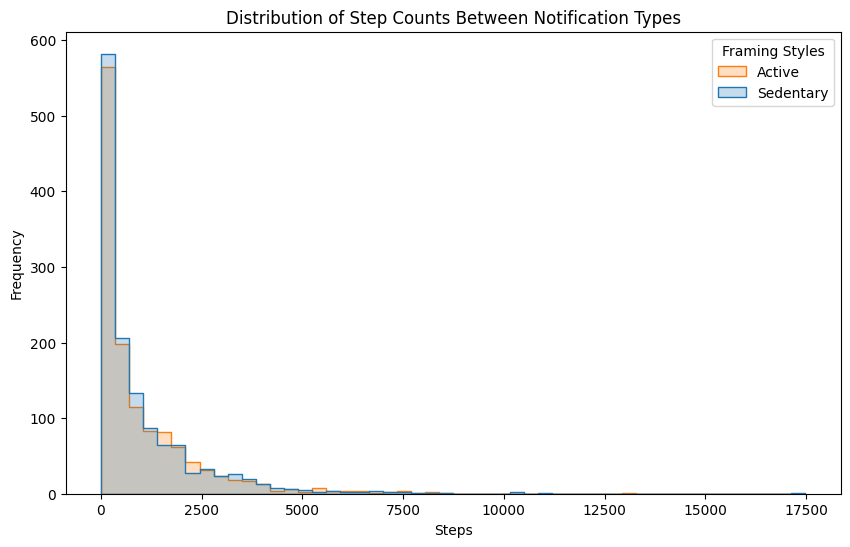

In [7]:
# Step 4: Histogram of step counts by notification type
plt.figure(figsize=(10, 6))
sns.histplot(data=mydata_steps_gf, x="total_steps", hue="notif_type", bins=50, element="step", color="black")
plt.title("Distribution of Step Counts Between Notification Types")
plt.xlabel("Steps")
plt.ylabel("Frequency")
plt.legend(title="Framing Styles", labels=["Active", "Sedentary"])
plt.savefig("steps_dist_all.png", transparent=True)
plt.show()


In [8]:
# Step 5: Negative Binomial GLM - Modeling the Effect of Notification Type on Step Counts
from pandas.api.types import CategoricalDtype

mydata_steps_gf['notif_type'] = mydata_steps_gf['notif_type'].astype(CategoricalDtype(categories=["Active", "Sedentary"], ordered=True))
mydata_steps_gf['user.index'] = mydata_steps_gf['user.index'].astype(str)  # Convert user.index to string for modeling

model_nb = glm("total_steps ~ notif_type", data=mydata_steps_gf, family=NegativeBinomial()).fit()
print(model_nb.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:            total_steps   No. Observations:                 2610
Model:                            GLM   Df Residuals:                     2608
Model Family:        NegativeBinomial   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -20608.
Date:                Fri, 25 Oct 2024   Deviance:                       6369.3
Time:                        14:58:48   Pearson chi2:                 5.13e+03
No. Iterations:                     6   Pseudo R-squ. (CS):          4.889e-06
Covariance Type:            nonrobust                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

/var/folders/rb/s8fz0j0d7xq20qvk9cm9vf9m0000gp/T/ipykernel_99585/3079901444.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  predictions_summary = mydata_steps_gf.groupby('notif_type')['predicted_steps'].agg(
/Users/zhiduokatara/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


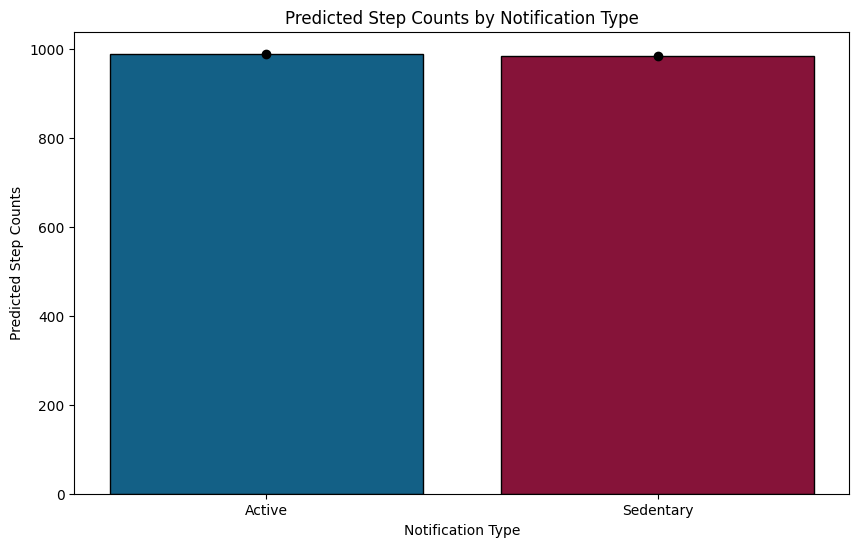

In [9]:
# Step 6: Predicted step counts by notification type with Confidence Intervals
mydata_steps_gf['predicted_steps'] = model_nb.predict(mydata_steps_gf[['notif_type']])

# Summary of predicted steps for plot
predictions_summary = mydata_steps_gf.groupby('notif_type')['predicted_steps'].agg(
    mean_pred='mean',
    lower_ci=lambda x: np.quantile(x, 0.025),
    upper_ci=lambda x: np.quantile(x, 0.975),
    se_pred=lambda x: x.std() / np.sqrt(len(x))
).reset_index()

# Plot predicted step counts by notification type
plt.figure(figsize=(10, 6))
sns.barplot(data=predictions_summary, x='notif_type', y='mean_pred', palette=['#006699', '#990033'], edgecolor="black")
plt.errorbar(x=range(len(predictions_summary)), y=predictions_summary['mean_pred'],
             yerr=predictions_summary['se_pred'], fmt='o', color='black')
plt.title("Predicted Step Counts by Notification Type")
plt.xlabel("Notification Type")
plt.ylabel("Predicted Step Counts")
plt.savefig("pred_rq1.png", transparent=True)
plt.show()


In [10]:
# Step 7: User Engagement (Response Time to Step > 60)
clean_steps_notif_users['steps.utime'] = pd.to_datetime(clean_steps_notif_users['steps.utime'])
ux_eng = clean_steps_notif_users.groupby(['user.index', 'decision.index', 'notif_type']).apply(
    lambda df: pd.Series({
        'first_step_time': df['steps.utime'].iloc[0],
        'step_ge_60_time': df.loc[df['steps'] >= 60, 'steps.utime'].min()
    })
).reset_index()

ux_eng['time_to_step_ge_60'] = (ux_eng['step_ge_60_time'] - ux_eng['first_step_time']).dt.total_seconds() / 60
ux_eng['time_to_step_ge_60'] = ux_eng['time_to_step_ge_60'].fillna(0.01)  # Handle missing and zero times

ux_eng

/var/folders/rb/s8fz0j0d7xq20qvk9cm9vf9m0000gp/T/ipykernel_99585/257101083.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ux_eng = clean_steps_notif_users.groupby(['user.index', 'decision.index', 'notif_type']).apply(


,user.index,decision.index,notif_type,first_step_time,step_ge_60_time,time_to_step_ge_60
0,1,0.0,Sedentary,2015-07-22 16:35:48.232100,2015-07-22 16:41:09.083807,5.347528
1,1,1.0,Active,2015-07-22 19:58:32.353972,2015-07-22 20:01:43.839612,3.191427
2,1,3.0,Sedentary,2015-07-22 23:33:32.236769,2015-07-22 23:57:51.621594,24.323080
3,1,5.0,Sedentary,2015-07-23 16:33:10.590636,NaT,0.010000
4,1,6.0,Active,2015-07-23 19:02:53.974052,NaT,0.010000
...,...,...,...,...,...,...
4421,37,223.0,Sedentary,NaT,NaT,0.010000
4422,37,224.0,Active,NaT,NaT,0.010000
4423,37,227.0,Active,NaT,NaT,0.010000
4424,37,228.0,Sedentary,NaT,NaT,0.010000


In [11]:
# Step 8: Fit a GLM with Gamma distribution for Response Time
model_response_time = glm("time_to_step_ge_60 ~ notif_type", data=ux_eng, family=Gamma(sm.families.links.log()))
response_time_fit = model_response_time.fit()
print(response_time_fit.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:     time_to_step_ge_60   No. Observations:                 4426
Model:                            GLM   Df Residuals:                     4424
Model Family:                   Gamma   Df Model:                            1
Link Function:                    log   Scale:                          15.217
Method:                          IRLS   Log-Likelihood:                    inf
Date:                Fri, 25 Oct 2024   Deviance:                       60869.
Time:                        14:58:51   Pearson chi2:                 6.73e+04
No. Iterations:                    10   Pseudo R-squ. (CS):                nan
Covariance Type:            nonrobust                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

/Users/zhiduokatara/anaconda3/lib/python3.11/site-packages/statsmodels/genmod/families/family.py:777: RuntimeWarning: divide by zero encountered in log
  ll_obs -= special.gammaln(weight_scale) + np.log(endog)
/Users/zhiduokatara/anaconda3/lib/python3.11/site-packages/statsmodels/genmod/generalized_linear_model.py:1767: RuntimeWarning: invalid value encountered in scalar subtract
  prsq = 1 - np.exp((self.llnull - self.llf) * (2 / self.nobs))


In [14]:
# # Filter and mutate data to create a notification type field
# clean_steps_notif_users = steps_notif_users.query("send == True and 'user.index' not in [29, 22]").copy()
# clean_steps_notif_users['notif_type'] = np.where(clean_steps_notif_users['send.active'], 'Active', 'Sedentary')
# clean_steps_notif_users['steps_date'] = pd.to_datetime(clean_steps_notif_users['steps.utime']).dt.date
# clean_steps_notif_users['day'] = clean_steps_notif_users.groupby('user.index')['steps_date'].transform(lambda x: pd.factorize(x)[0] + 1)

# # Filter out any missing notification types
# clean_steps_notif_users = clean_steps_notif_users.dropna(subset=['notif_type'])

# # Exclude user #22 for abnormal steps
# mydata_steps_gf = clean_steps_notif_users.query("`user.index` != 22")[['user.index', 'steps_date', 'day', 'decision.index', 'notif_type', 'steps', 'selfeff.intake_r']]

# # Summarize and group by user index for analysis
# mydata_steps_gf = mydata_steps_gf.groupby(['user.index', 'steps_date', 'day', 'notif_type', 'decision.index', 'selfeff.intake_r']).agg(
#     total_steps=('steps', 'sum')).reset_index()
# print("Unique User Count:", len(mydata_steps_gf['user.index'].unique()))

